In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#Input fits files
m4fits = "./lrisr/1dspec/OIIB146m-4_w10_fcal.fits"
m5fits = "./lrisr/1dspec/OIIB146m-5_w15_fcal.fits"
s2fits = "./lrisr/1dspec/OIIB146s-2_w10_fcal.fits"

In [3]:
# Vacuum setting
# Blue line
wb = 3726.032
# Red line
wr = 3728.815

# OIIB146m-4

In [4]:
#Extract data from fits files
m4 = fits.open(m4fits)
m4wave = m4[0].data #Wavelength
m4flux = m4[1].data #Flux
m4err = m4[2].data #Flux uncertainty

In [5]:
#Add a mask on wavelengths 
mask = np.where((m4wave>9200)&(m4wave<9300))

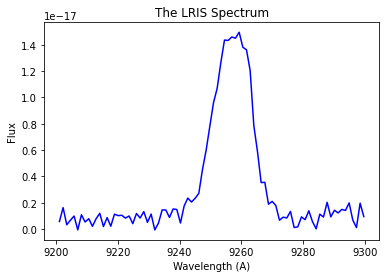

In [6]:
#Plot the LRIS spectrum
plt.figure()
plt.tight_layout()

plt.title("The LRIS Spectrum")
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.plot(m4wave[mask],m4flux[mask],color='b')  

In [20]:
# Doublet ratio = F(red) / F(blue)
dr_m4 = 1.5

In [21]:
# w0:  wavelength where continuum level is y0
w0 = 9230.0

In [22]:
def func(x, z, sigma, a, m, y0):  
    return (a * np.exp(-(x - wb * (1+z))**2 / (2. * sigma **2))
           + dr_m4 * a * np.exp(-(x - wr * (1+z))**2 / (2. * sigma **2)) + m * (x - w0) + y0)

In [23]:
#Initial guess of redshift
z_guess = 9253/3726 - 1
z_guess

1.4833601717659688

In [46]:
guess = np.array([1.4832, 4.2, 0.80e-17, 0, 0.05e-17])  #systemic z, sigma (in A), amplitude, continuum slope, continuum 

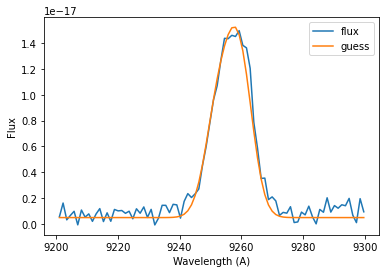

In [47]:
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")

yguess = func(m4wave,guess[0],guess[1],guess[2],guess[3],guess[4])
plt.plot(m4wave[mask],m4flux[mask],label='flux') 
#plt.plot(m4wave[mask], m4err[mask], label='err')
plt.plot(m4wave[mask], yguess[mask], label='guess')
plt.legend()

In [48]:
# Fit with SciPy
p, pcov = curve_fit(func, m4wave[mask], m4flux[mask], guess, m4err[mask])
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')

Fit Completed


In [49]:
#Results
print('redshift = '+str(p[0])+', sigma = '+str(p[1])+', amplitude = '+str(p[2])
      +', continuum slope = '+str(p[3])+', continuum = '+str(p[4]))
perr

redshift = 1.48331741820282, sigma = 4.245111469270103, amplitude = 7.819402399676297e-18, continuum slope = 3.0522167371372265e-21, continuum = 8.5825794991704275e-19


array([2.81852734e-05, 1.40143438e-01, 2.08852612e-19, 2.11187360e-21,
       7.49507676e-20])

In [53]:
## Resultant systemic redshift
print('z = '+str(p[0])+' ± '+str(perr[0]))
#Resultant sigma (velocity dispersion): [sigma_in_A/(wb*(1+z))]*c
print('Sigma = '+str(f'{p[1]*2.99792e5/(wb*(1+p[0])):.1f}')+' ± '+str(perr[1]*2.99792e5/(wb*(1+p[0])))+' km/s')
#Resultant amplitude
print('Amplitude = '+str(p[2])+' ± 2e-19 erg*s^(-1)*cm^(-2)*A^(-1)')
#Resultant continuum slope
print('Continuum slope = '+str(p[3])+' ± 2e-21 erg*s^(-1)*cm^(-2)*A^(-2)')
#Resultant continuum flux
print('Continuum flux = '+str(p[4])+' ± 7e-20 erg*s^(-1)*cm^(-2)*A^(-1)')

z = 1.48331741820282 ± 2.8185273375007936e-05
Sigma = 137.5 ± 4.5406078148502305 km/s
Amplitude = 7.819402399676297e-18 ± 2e-19 erg*s^(-1)*cm^(-2)*A^(-1)
Continuum slope = 3.0522167371372265e-21 ± 2e-21 erg*s^(-1)*cm^(-2)*A^(-2)
Continuum flux = 8.5825794991704275e-19 ± 7e-20 erg*s^(-1)*cm^(-2)*A^(-1)


In [51]:
# Calculate 'Goodness of Fit'
model = func(m4wave[mask],p[0],p[1],p[2],p[3],p[4])
term = ((m4flux[mask]-model) / m4err[mask])**2
dof = m4wave[mask].size - guess.size
chi2 = np.sum(term) / dof
chi2

1.1976670674443213

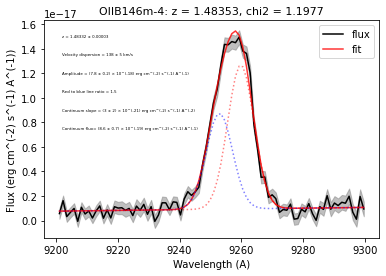

In [54]:
## Plot the results
yfit = model
yblue = lambda x, z, sigma, a, m, y0:  a * np.exp(-(x - wb * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0
yred  = lambda x, z, sigma, a, m, y0:  dr_m4 * a * np.exp(-(x - wr * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0


fig = plt.figure()
plt.tight_layout()
plt.title("OIIB146m-4: z = 1.48353, chi2 = 1.1977", fontsize = 11)

#Present results
dy = np.max(m4flux[mask]) - np.min(m4flux[mask])
dx = np.max(m4wave[mask]) - np.min(m4wave[mask])
epsx = 0.01 * dx
epsy = 0.1 * dy
plt.text(np.min(m4wave[mask])+epsx, np.max(m4flux[mask]), 'z = 1.48332 ± 0.00003', fontsize = 4)
plt.text(np.min(m4wave[mask])+epsx, np.max(m4flux[mask]) -  epsy, 'Velocity dispersion = 138 ± 5 km/s', fontsize = 4)
plt.text(np.min(m4wave[mask])+epsx, np.max(m4flux[mask]) - 2 * epsy, 'Amplitude = (7.8 ± 0.2) × 10^(-18) erg cm^(-2) s^(-1) A^(-1)', fontsize = 4)
plt.text(np.min(m4wave[mask])+epsx, np.max(m4flux[mask]) - 3 * epsy, 'Red to blue line ratio = 1.5', fontsize = 4)
plt.text(np.min(m4wave[mask])+epsx, np.max(m4flux[mask]) - 4 * epsy, 'Continuum slope = (3 ± 2) × 10^(-21) erg cm^(-2) s^(-1) A^(-2)', fontsize = 4)
plt.text(np.min(m4wave[mask])+epsx, np.max(m4flux[mask]) - 5 * epsy, 'Continuum flux= (8.6 ± 0.7) × 10^(-19) erg cm^(-2) s^(-1) A^(-1)', fontsize = 4)

plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (erg cm^(-2) s^(-1) A^(-1))")
plt.plot(m4wave[mask],m4flux[mask],'k',label='flux')
plt.plot(m4wave[mask],yfit,'r',label='fit',alpha=0.8)
plt.plot(m4wave[mask],yblue(m4wave[mask],p[0],p[1],p[2],p[3],p[4]), 'b:',alpha=0.5)
plt.plot(m4wave[mask],yred(m4wave[mask],p[0],p[1],p[2],p[3],p[4]), 'r:',alpha=0.5)
plt.fill_between(m4wave[mask], m4flux[mask]-m4err[mask], m4flux[mask]+m4err[mask], color='grey', alpha=0.5)
plt.legend()
plt.savefig('m4.pdf')
#plt.plot(wave,yguess,'k:')

#  OIIB146m-5

In [55]:
#Extract data from fits files
m5 = fits.open(m5fits)
m5wave = m5[0].data #Wavelength
m5flux = m5[1].data #Flux
m5err = m5[2].data #Flux uncertainty

In [56]:
#Add a mask on wavelengths
mask = np.where((m5wave>9150)&(m5wave<9275))

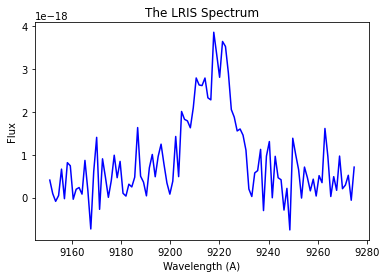

In [57]:
#Plot the LRIS spectrum
plt.figure()
plt.tight_layout()

plt.title("The LRIS Spectrum")
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.plot(m5wave[mask],m5flux[mask],color='b')  

In [58]:
# Doublet ratio = F(red) / F(blue)
dr_m5 = 1.5

In [59]:
# w0:  wavelength where continuum level is y0
w0 = 9175.0

In [60]:
def func(x, z, sigma, a, m, y0):  
    return (a * np.exp(-(x - wb * (1+z))**2 / (2. * sigma **2))
           + dr_m5 * a * np.exp(-(x - wr * (1+z))**2 / (2. * sigma **2)) + m * (x - w0) + y0)

In [61]:
#Initial guess of redshift
z_guess = 9220/3729 - 1
z_guess

1.4725127379994638

In [62]:
guess = np.array([1.4726, 2.9, 2.3e-18, 0, 0.4e-18])  # systemic z, sigma (in A), amplitude, continuum slope, continuum 

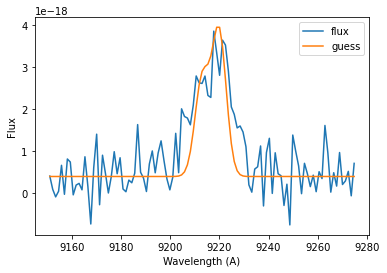

In [63]:
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")

yguess = func(m5wave,guess[0],guess[1],guess[2],guess[3],guess[4])
plt.plot(m5wave[mask], m5flux[mask],label='flux') 
#plt.plot(m5wave[mask], m5err[mask], label='err')
plt.plot(m5wave[mask], yguess[mask], label='guess')
plt.legend()

In [64]:
# Fit with SciPy
p, pcov = curve_fit(func, m5wave[mask], m5flux[mask], guess, m5err[mask])
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')

Fit Completed


In [65]:
#Results
print('z_sys = '+str(p[0])+', sigma = '+str(p[1])+', amplitude = '+str(p[2])
      +', continuum slope = '+str(p[3])+', continuum = '+str(p[4]))
perr

z_sys = 1.472645480136102, sigma = 7.142858292580903, amplitude = 1.2425929868270153e-18, continuum slope = 5.686814269062665e-22, continuum = 4.171070464898049e-19


array([1.63572517e-04, 7.23460470e-01, 9.90471350e-20, 1.37424552e-21,
       7.52447287e-20])

In [66]:
# Resultant systemic redshift
print('z = '+str(p[0])+' ± '+str(perr[0]))
#Resultant sigma (velocity dispersion): [sigma_in_A/(wb*(1+z))]*c
print('Sigma = '+str(f'{p[1]*2.99792e5/(wb*(1+p[0])):.1f}')+' ± '+str(perr[1]*2.99792e5/(wb*(1+p[0])))+' km/s')
#Resultant amplitude
print('Amplitude = '+str(p[2])+' ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-1)')
#Resultant continuum slope
print('Continuum slope = '+str(p[3])+' ± 1e-21 erg*s^(-1)*cm^(-2)*A^(-2)')
#Resultant continuum flux
print('Continuum flux = '+str(p[4])+' ± 8e-20 erg*s^(-1)*cm^(-2)*A^(-1)')

z = 1.472645480136102 ± 0.00016357251726096774
Sigma = 232.4 ± 23.54108155426827 km/s
Amplitude = 1.2425929868270153e-18 ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-1)
Continuum slope = 5.686814269062665e-22 ± 1e-21 erg*s^(-1)*cm^(-2)*A^(-2)
Continuum flux = 4.171070464898049e-19 ± 8e-20 erg*s^(-1)*cm^(-2)*A^(-1)


In [67]:
# Calculate 'Goodness of Fit'
model = func(m5wave[mask],p[0],p[1],p[2],p[3],p[4])
term = ((m5flux[mask]-model) / m5err[mask])**2  
dof = m5wave[mask].size - guess.size
chi2 = np.sum(term) / dof
chi2

1.4904162035087696

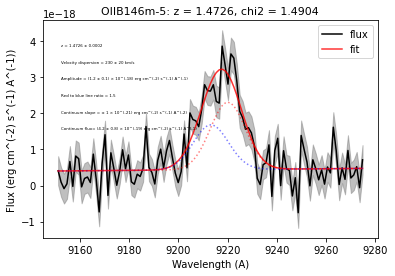

In [68]:
## Plot the results
yfit = model
yblue = lambda x, z, sigma, a, m, y0:  a * np.exp(-(x - wb * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0
yred  = lambda x, z, sigma, a, m, y0:  dr_m5 * a * np.exp(-(x - wr * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0


fig = plt.figure()
plt.tight_layout()
plt.title("OIIB146m-5: z = 1.4726, chi2 = 1.4904", fontsize = 11)
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (erg cm^(-2) s^(-1) A^(-1))")
plt.plot(m5wave[mask],m5flux[mask],'k',label='flux')
plt.plot(m5wave[mask],yfit,'r',label='fit',alpha=0.8)
plt.plot(m5wave[mask],yblue(m5wave[mask],p[0],p[1],p[2],p[3],p[4]), 'b:',alpha=0.5)
plt.plot(m5wave[mask],yred(m5wave[mask],p[0],p[1],p[2],p[3],p[4]), 'r:',alpha=0.5)
plt.fill_between(m5wave[mask], m5flux[mask]-m5err[mask], m5flux[mask]+m5err[mask], color='grey', alpha=0.5)

#Present results
dy = np.max(m5flux[mask]) - np.min(m5flux[mask])
dx = np.max(m5wave[mask]) - np.min(m5wave[mask])
epsx = 0.01 * dx
epsy = 0.1 * dy
plt.text(np.min(m5wave[mask])+epsx, np.max(m5flux[mask]), 'z = 1.4726 ± 0.0002', fontsize = 4)
plt.text(np.min(m5wave[mask])+epsx, np.max(m5flux[mask]) -  epsy, 'Velocity dispersion = 230 ± 20 km/s', fontsize = 4)
plt.text(np.min(m5wave[mask])+epsx, np.max(m5flux[mask]) - 2 * epsy, 'Amplitude = (1.2 ± 0.1) × 10^(-18) erg cm^(-2) s^(-1) A^(-1)', fontsize = 4)
plt.text(np.min(m5wave[mask])+epsx, np.max(m5flux[mask]) - 3 * epsy, 'Red to blue line ratio = 1.5', fontsize = 4)
plt.text(np.min(m5wave[mask])+epsx, np.max(m5flux[mask]) - 4 * epsy, 'Continuum slope = ± 1 × 10^(-21) erg cm^(-2) s^(-1) A^(-2)', fontsize = 4)
plt.text(np.min(m5wave[mask])+epsx, np.max(m5flux[mask]) - 5 * epsy, 'Continuum flux= (4.2 ± 0.8) × 10^(-19) erg cm^(-2) s^(-1) A^(-1)', fontsize = 4)

plt.legend()
plt.savefig('m5.pdf')

# OIIB146s-2

In [78]:
#Extract data from fits files
s2 = fits.open(s2fits)
s2wave = s2[0].data #Wavelength
s2flux = s2[1].data #Flux
s2err = s2[2].data #Flux uncertainty

In [79]:
#Add a mask on wavelengths 
mask = np.where((s2wave>9180)&(s2wave<9300))

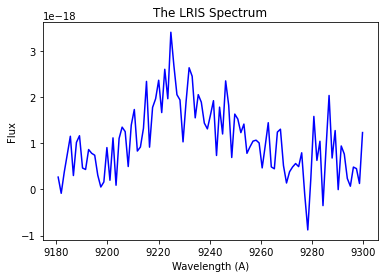

In [80]:
#Plot the LRIS spectrum
plt.figure()
plt.tight_layout()

plt.title("The LRIS Spectrum")
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.plot(s2wave[mask],s2flux[mask],color='b')  

In [81]:
# Doublet ratio = F(red) / F(blue)
dr_s2 = 0.4

In [82]:
# w0:  wavelength where continuum level is y0
w0 = 9270.0

In [83]:
def func(x, z, sigma, a, m, y0):  
    return (a * np.exp(-(x - wb * (1+z))**2 / (2. * sigma **2))
           + dr_s2 * a * np.exp(-(x - wr * (1+z))**2 / (2. * sigma **2)) + m * (x - w0) + y0)

In [84]:
#Initial guess of redshift
z_guess = 9224/3729 - 1
z_guess

1.473585411638509

In [85]:
guess = np.array([1.4755, 10.0, 2.2e-18, 0, 0.4e-18])  # systemic z, sigma (in A), amplitude, continuum slope, continuum 

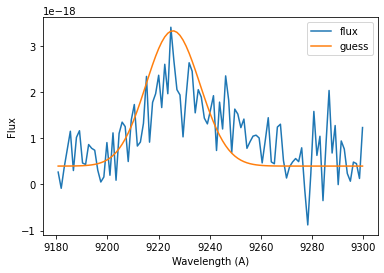

In [86]:
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")

yguess = func(s2wave,guess[0],guess[1],guess[2],guess[3],guess[4])
plt.plot(s2wave[mask], s2flux[mask],label='flux') 
#plt.plot(m5wave[mask], m5err[mask], label='err')
plt.plot(s2wave[mask], yguess[mask], label='guess')
plt.legend()

In [87]:
# Fit with SciPy
p, pcov = curve_fit(func, s2wave[mask], s2flux[mask], guess, s2err[mask])
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')

Fit Completed


In [88]:
#Results
print('z_sys = '+str(p[0])+', sigma = '+str(p[1])+', amplitude = '+str(p[2])
      +', continuum slope = '+str(p[3])+', continuum = '+str(p[4]))
perr

z_sys = 1.476539569403445, sigma = 15.017795125849366, amplitude = 1.1682301062099807e-18, continuum slope = 1.4086304728735918e-21, continuum = 5.819751219164677e-19


array([4.26121334e-04, 2.07761357e+00, 1.18059236e-19, 1.75264436e-21,
       9.88876723e-20])

In [89]:
# Resultant systemic redshift
print('z = '+str(p[0])+' ± '+str(perr[0]))
#Resultant sigma (velocity dispersion): [sigma_in_A/(wb*(1+z))]*c
print('Sigma = '+str(f'{p[1]*2.99792e5/(wb*(1+p[0])):.1f}')+' ± '+str(perr[1]*2.99792e5/(wb*(1+p[0])))+' km/s')
#Resultant amplitude
print('Amplitude = '+str(p[2])+' ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-1)')
#Resultant continuum slope
print('Continuum slope = '+str(p[3])+' ± 2e-21 erg*s^(-1)*cm^(-2)*A^(-2)')
#Resultant continuum flux
print('Continuum flux = '+str(p[4])+' ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-1)')

z = 1.476539569403445 ± 0.00042612133447463636
Sigma = 487.9 ± 67.49831962446484 km/s
Amplitude = 1.1682301062099807e-18 ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-1)
Continuum slope = 1.4086304728735918e-21 ± 2e-21 erg*s^(-1)*cm^(-2)*A^(-2)
Continuum flux = 5.819751219164677e-19 ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-1)


In [90]:
# Calculate 'Goodness of Fit'
model = func(s2wave[mask],p[0],p[1],p[2],p[3],p[4])
term = ((s2flux[mask]-model) / s2err[mask])**2  
dof = s2wave[mask].size - guess.size
chi2 = np.sum(term) / dof
chi2

0.8895629105294968

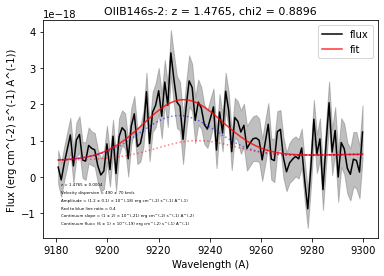

In [91]:
## Plot the results
yfit = model
yblue = lambda x, z, sigma, a, m, y0:  a * np.exp(-(x - wb * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0
yred  = lambda x, z, sigma, a, m, y0:  dr_s2 * a * np.exp(-(x - wr * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0


fig = plt.figure()
plt.tight_layout()
plt.title("OIIB146s-2: z = 1.4765, chi2 = 0.8896", fontsize = 11)
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (erg cm^(-2) s^(-1) A^(-1))")
plt.plot(s2wave[mask],s2flux[mask],'k',label='flux')
plt.plot(s2wave[mask],yfit,'r',label='fit',alpha=0.8)
plt.plot(s2wave[mask],yblue(s2wave[mask],p[0],p[1],p[2],p[3],p[4]), 'b:',alpha=0.5)
plt.plot(s2wave[mask],yred(s2wave[mask],p[0],p[1],p[2],p[3],p[4]), 'r:',alpha=0.5)
plt.fill_between(s2wave[mask], s2flux[mask]-s2err[mask], s2flux[mask]+s2err[mask], color='grey', alpha=0.5)

#Present results
dy = np.max(s2flux[mask]) - np.min(s2flux[mask])
dx = np.max(s2wave[mask]) - np.min(s2wave[mask])
epsx = 0.01 * dx
epsy = 0.05 * dy
plt.text(np.min(s2wave[mask])+epsx, np.min(s2flux[mask]) + 3 * epsy, 'z = 1.4765 ± 0.0004', fontsize = 4)
plt.text(np.min(s2wave[mask])+epsx, np.min(s2flux[mask]) + 2 * epsy, 'Velocity dispersion = 490 ± 70 km/s', fontsize = 4)
plt.text(np.min(s2wave[mask])+epsx, np.min(s2flux[mask]) + 1 * epsy, 'Amplitude = (1.2 ± 0.1) × 10^(-18) erg cm^(-2) s^(-1) A^(-1)', fontsize = 4)
plt.text(np.min(s2wave[mask])+epsx, np.min(s2flux[mask]), 'Red to blue line ratio = 0.4', fontsize = 4)
plt.text(np.min(s2wave[mask])+epsx, np.min(s2flux[mask]) - 1 * epsy, 'Continuum slope = (1 ± 2) × 10^(-21) erg cm^(-2) s^(-1) A^(-2)', fontsize =4)
plt.text(np.min(s2wave[mask])+epsx, np.min(s2flux[mask]) - 2 * epsy, 'Continuum flux= (6 ± 1) × 10^(-19) erg cm^(-2) s^(-1) A^(-1)', fontsize = 4)

plt.legend()
plt.savefig('s2.pdf')